✅ Libraries loaded

LOADING XGBOOST MODELS AND DATA
✅ Loaded: X_train
✅ Loaded: X_test
✅ Loaded: y_train
✅ Loaded: y_test
✅ Loaded: xgboost_model
⚠️  Asset 'xgboost_model_early_stopping' not found
   Make sure you've materialized this asset in Dagster first!
⚠️  Asset 'xgboost_model_grid_search' not found
   Make sure you've materialized this asset in Dagster first!
⚠️  Asset 'xgboost_model_optimized' not found
   Make sure you've materialized this asset in Dagster first!
✅ Loaded: evaluate_xgboost
⚠️  Asset 'evaluate_early_stopping' not found
   Make sure you've materialized this asset in Dagster first!
⚠️  Asset 'evaluate_grid_search' not found
   Make sure you've materialized this asset in Dagster first!
⚠️  Asset 'evaluate_optimized' not found
   Make sure you've materialized this asset in Dagster first!

✅ All assets loaded!

EVALUATING ALL MODELS

Found 1 models to evaluate:
  ✓ Regularized

📊 Evaluating Regularized...

PERFORMANCE COMPARISON TABLE


             Train AUC  Test 

/tmp/ipykernel_53774/3046044307.py:290: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspaces/telekom_interview/.pixi/envs/ci-validation/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


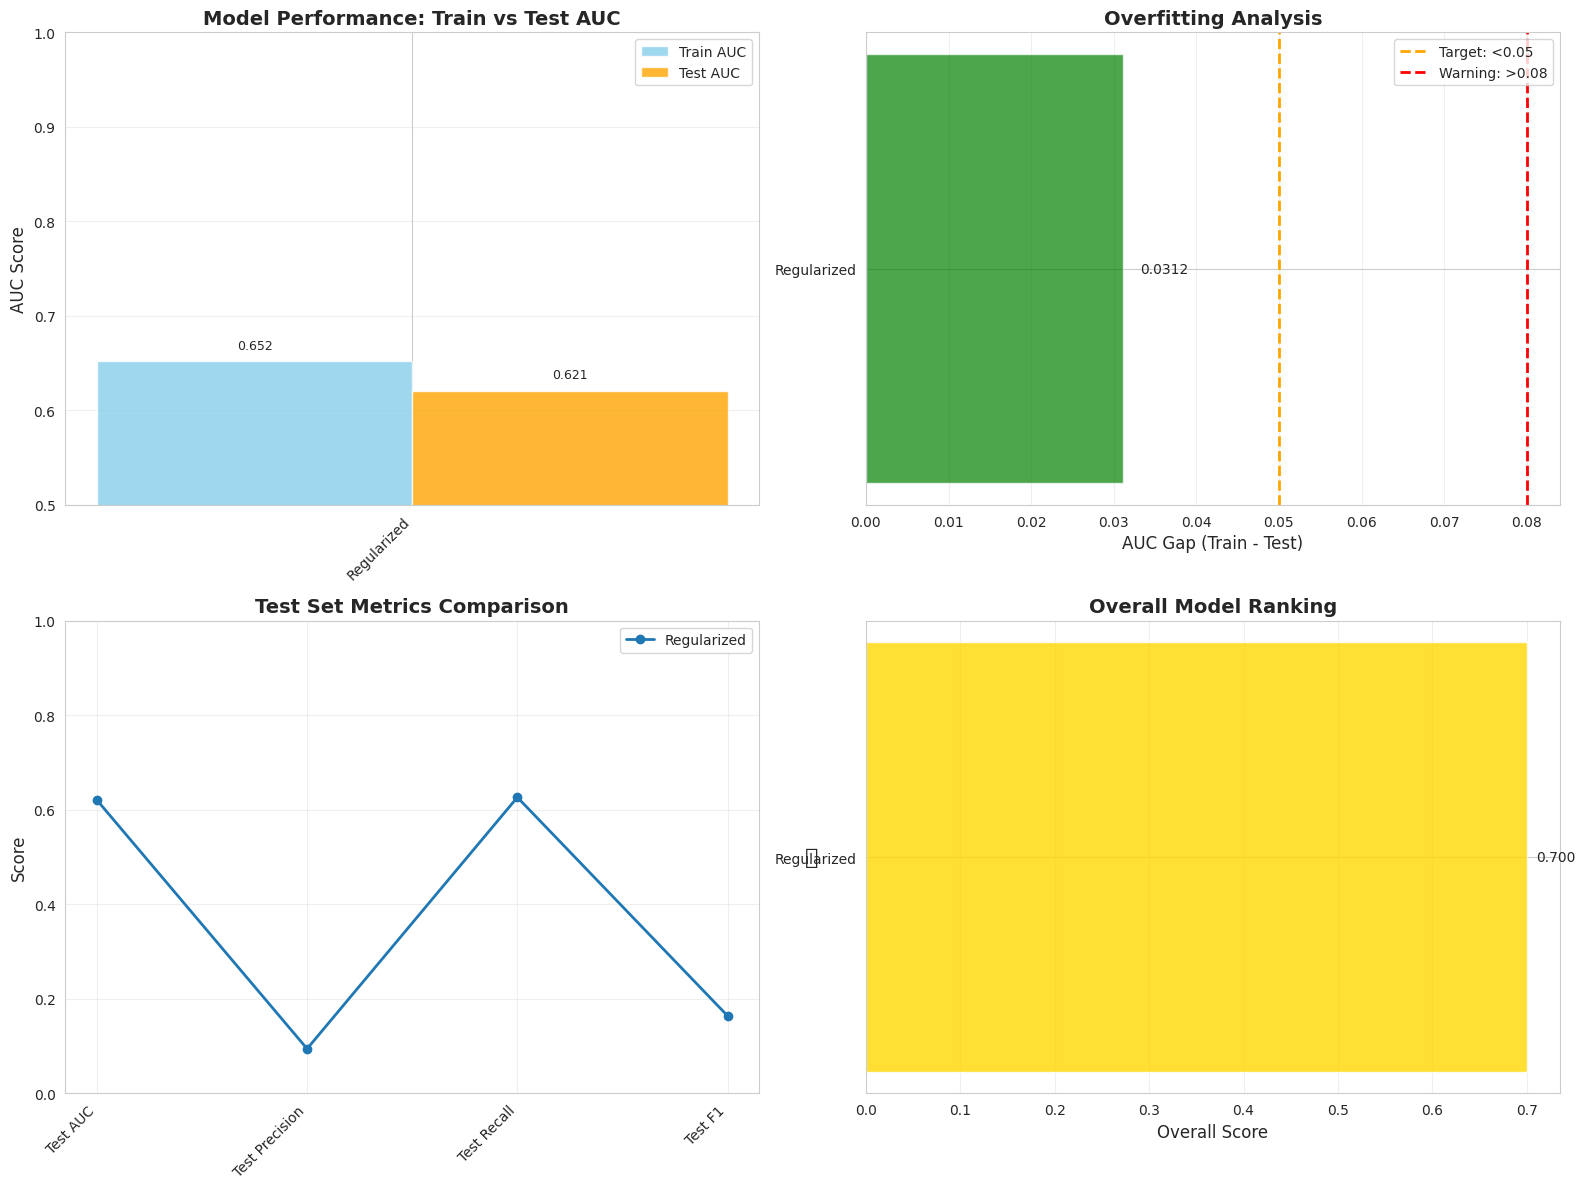

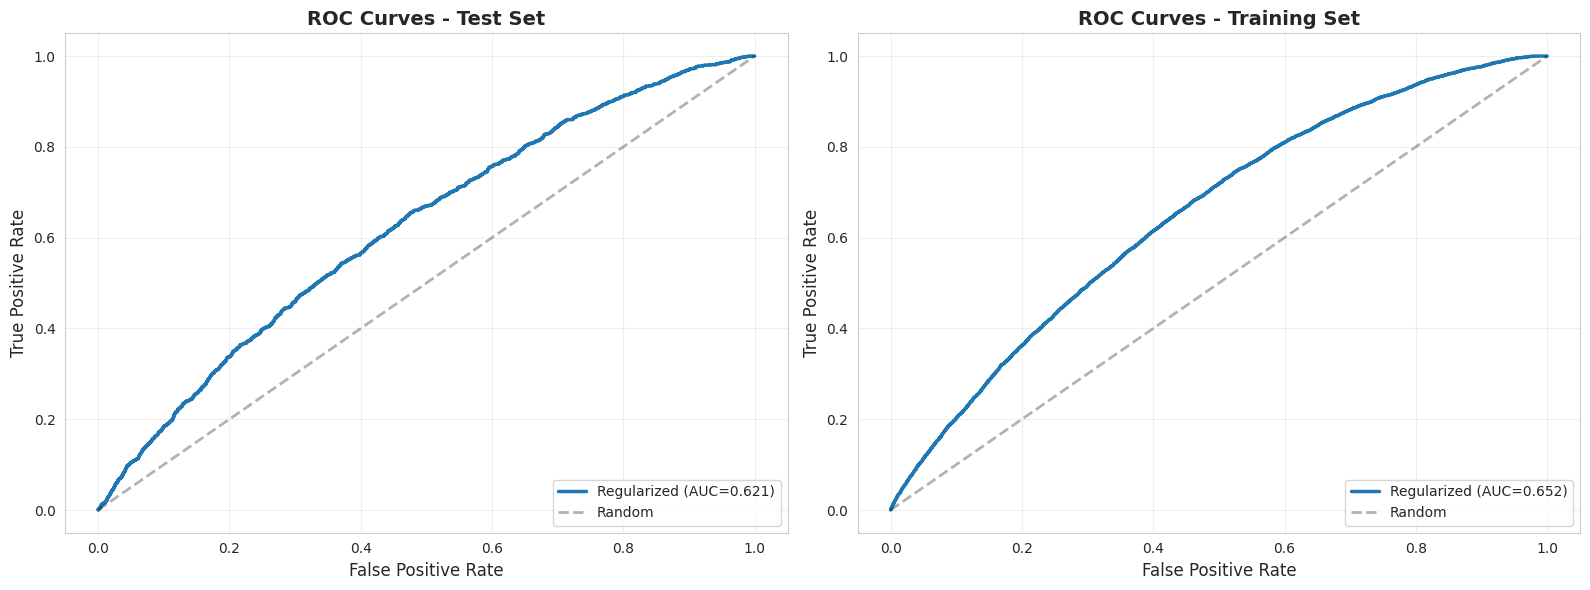

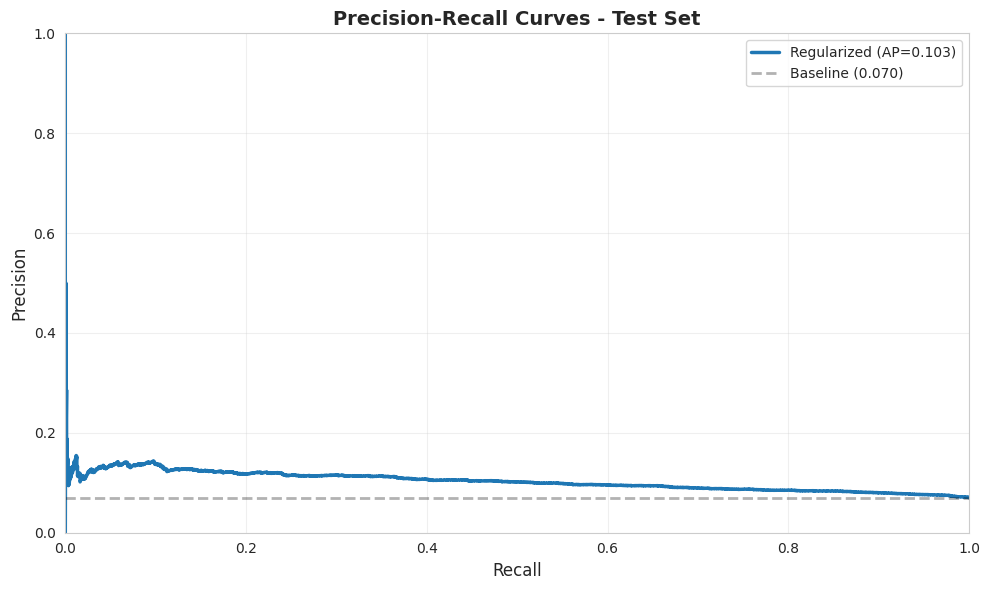

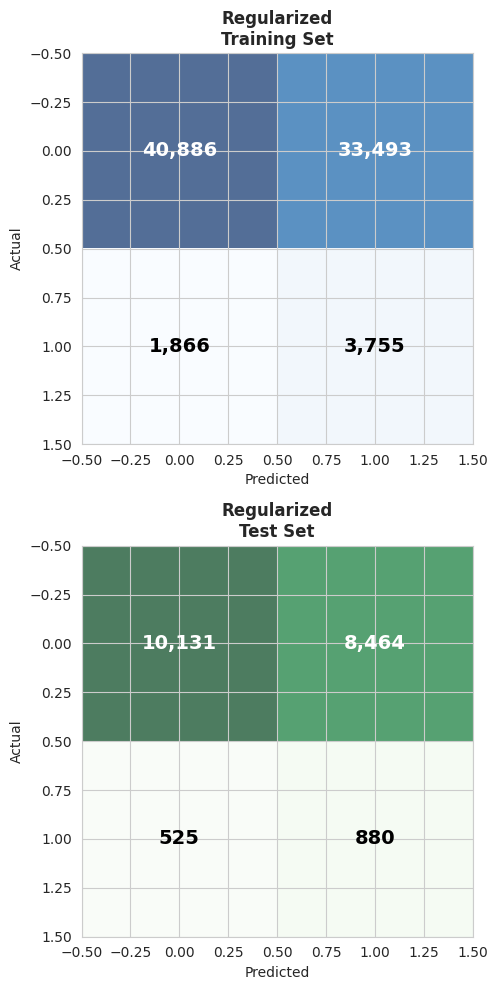


DETAILED CLASSIFICATION REPORTS

--------------------------------------------------------------------------------
REGULARIZED - TEST SET
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   No Upsell     0.9507    0.5448    0.6927     18595
      Upsell     0.0942    0.6263    0.1637      1405

    accuracy                         0.5505     20000
   macro avg     0.5225    0.5856    0.4282     20000
weighted avg     0.8906    0.5505    0.6555     20000

📊 BUSINESS METRICS:
   Precision: 9.42% - Of targeted customers, 9.42% will upsell
   Recall: 62.63% - We capture 62.63% of all upsell opportunities
   ROC-AUC: 0.6208 - Overall discrimination ability

FEATURE IMPORTANCE COMPARISON


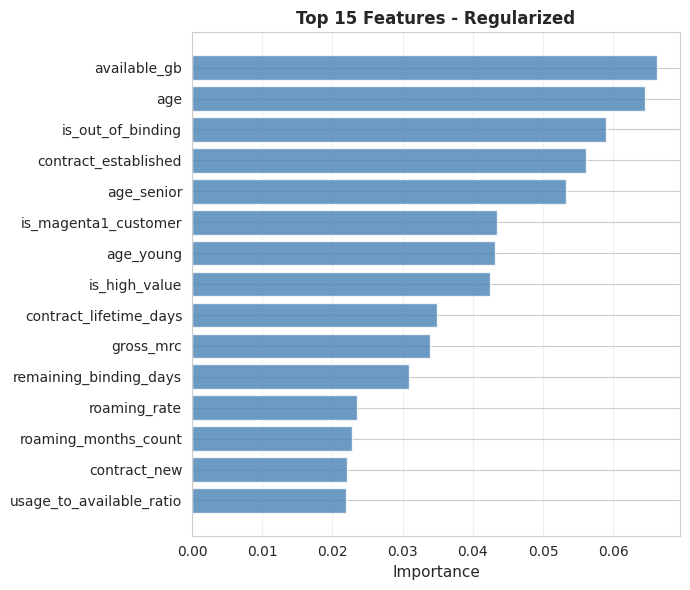


Regularized - Top 10 Features:
               feature  importance
          available_gb    0.066210
                   age    0.064565
     is_out_of_binding    0.058947
  contract_established    0.056199
            age_senior    0.053252
  is_magenta1_customer    0.043396
             age_young    0.043212
         is_high_value    0.042423
contract_lifetime_days    0.034905
             gross_mrc    0.033938

MODEL PARAMETERS COMPARISON

Regularized:
   max_depth: 3
   min_child_weight: 5
   gamma: 0.1
   learning_rate: 0.05
   n_estimators: 200
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 1.0
   reg_lambda: 5.0
   objective: binary:logistic
   eval_metric: auc

THRESHOLD OPTIMIZATION

Regularized - Different Classification Thresholds:

 Threshold  Precision     Recall         F1   Targeted
----------------------------------------------------
       0.1      7.03%    100.00%     0.1313     19,999
       0.2      7.09%     99.93%     0.1324     19,804
       0.3      7.

In [ ]:
# ============================================================================
# XGBoost Models Evaluation & Comparison
# This notebook loads and compares all XGBoost model variants
# ============================================================================

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, average_precision_score,
    precision_recall_curve
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded")

# ============================================================================
# LOAD DAGSTER ASSETS
# ============================================================================

def load_artifact(artifact_name: str, storage_dir="../tmpbo8yb74n/storage/"):
    """Load artifacts materialized by Dagster"""
    artifact_path = os.path.join(storage_dir, artifact_name)
    
    if not os.path.exists(artifact_path):
        print(f"⚠️  Asset '{artifact_name}' not found")
        print(f"   Make sure you've materialized this asset in Dagster first!")
        return None
    
    with open(artifact_path, 'rb') as fp:
        artifact = pickle.load(fp)
    
    print(f"✅ Loaded: {artifact_name}")
    return artifact

print("\n" + "="*80)
print("LOADING XGBOOST MODELS AND DATA")
print("="*80)

# Load train/test data
X_train = load_artifact("X_train")
X_test = load_artifact("X_test")
y_train = load_artifact("y_train")
y_test = load_artifact("y_test")

# Load all XGBoost models
xgb_regularized = load_artifact("xgboost_model")  # Your current regularized model
xgb_early_stopping = load_artifact("xgboost_model_early_stopping")
xgb_grid_search = load_artifact("xgboost_model_grid_search")
xgb_optimized = load_artifact("xgboost_model_optimized")

# Load evaluations
eval_regularized = load_artifact("evaluate_xgboost")
eval_early_stopping = load_artifact("evaluate_early_stopping")
eval_grid_search = load_artifact("evaluate_grid_search")
eval_optimized = load_artifact("evaluate_optimized")

print("\n✅ All assets loaded!")

# ============================================================================
# HELPER FUNCTION: EVALUATE A MODEL
# ============================================================================

def evaluate_model_detailed(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive evaluation of a single model
    """
    results = {}
    
    # Training set predictions
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_pred = model.predict(X_train)
    
    # Test set predictions
    test_pred_proba = model.predict_proba(X_test)[:, 1]
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    results['train_auc'] = roc_auc_score(y_train, train_pred_proba)
    results['train_precision'] = precision_score(y_train, train_pred)
    results['train_recall'] = recall_score(y_train, train_pred)
    results['train_f1'] = f1_score(y_train, train_pred)
    
    results['test_auc'] = roc_auc_score(y_test, test_pred_proba)
    results['test_avg_precision'] = average_precision_score(y_test, test_pred_proba)
    results['test_precision'] = precision_score(y_test, test_pred)
    results['test_recall'] = recall_score(y_test, test_pred)
    results['test_f1'] = f1_score(y_test, test_pred)
    
    results['auc_gap'] = results['train_auc'] - results['test_auc']
    results['test_cm'] = confusion_matrix(y_test, test_pred)
    results['train_cm'] = confusion_matrix(y_train, train_pred)
    
    results['test_pred_proba'] = test_pred_proba
    results['train_pred_proba'] = train_pred_proba
    
    return results

# ============================================================================
# EVALUATE ALL MODELS
# ============================================================================

print("\n" + "="*80)
print("EVALUATING ALL MODELS")
print("="*80)

models_to_evaluate = {}

# Check which models were loaded successfully
if xgb_regularized is not None:
    models_to_evaluate['Regularized'] = xgb_regularized['model']
    
if xgb_early_stopping is not None:
    models_to_evaluate['Early Stopping'] = xgb_early_stopping['model']
    
if xgb_grid_search is not None:
    models_to_evaluate['Grid Search'] = xgb_grid_search['model']
    
if xgb_optimized is not None:
    models_to_evaluate['Optimized'] = xgb_optimized['model']

print(f"\nFound {len(models_to_evaluate)} models to evaluate:")
for name in models_to_evaluate.keys():
    print(f"  ✓ {name}")

# Evaluate each model
all_results = {}
for name, model in models_to_evaluate.items():
    print(f"\n📊 Evaluating {name}...")
    all_results[name] = evaluate_model_detailed(model, X_train, X_test, y_train, y_test, name)

# ============================================================================
# CREATE COMPARISON TABLE
# ============================================================================

print("\n" + "="*80)
print("PERFORMANCE COMPARISON TABLE")
print("="*80)

comparison_data = {}
for name, results in all_results.items():
    comparison_data[name] = {
        'Train AUC': results['train_auc'],
        'Test AUC': results['test_auc'],
        'AUC Gap': results['auc_gap'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall'],
        'Test F1': results['test_f1'],
        'Avg Precision': results['test_avg_precision']
    }

comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.round(4)

print("\n")
print(comparison_df.to_string())

# Find best models
best_test_auc = comparison_df['Test AUC'].idxmax()
best_generalization = comparison_df['AUC Gap'].idxmin()
best_f1 = comparison_df['Test F1'].idxmax()

print("\n" + "="*80)
print("🏆 BEST MODELS BY METRIC")
print("="*80)
print(f"\n🥇 Best Test AUC: {best_test_auc}")
print(f"   Score: {comparison_df.loc[best_test_auc, 'Test AUC']:.4f}")

print(f"\n🥇 Best Generalization (smallest gap): {best_generalization}")
print(f"   Gap: {comparison_df.loc[best_generalization, 'AUC Gap']:.4f}")

print(f"\n🥇 Best F1 Score: {best_f1}")
print(f"   Score: {comparison_df.loc[best_f1, 'Test F1']:.4f}")

# Overall recommendation
comparison_df['Overall Score'] = (
    0.50 * (comparison_df['Test AUC'] / comparison_df['Test AUC'].max()) +
    0.30 * (1 - comparison_df['AUC Gap'] / comparison_df['AUC Gap'].max()) +
    0.20 * (comparison_df['Test F1'] / comparison_df['Test F1'].max())
)

best_overall = comparison_df['Overall Score'].idxmax()

print("\n" + "="*80)
print("💡 OVERALL RECOMMENDATION")
print("="*80)
print(f"\n🏆 BEST OVERALL MODEL: {best_overall}")
print(f"   Test AUC: {comparison_df.loc[best_overall, 'Test AUC']:.4f}")
print(f"   AUC Gap:  {comparison_df.loc[best_overall, 'AUC Gap']:.4f}")
print(f"   Test F1:  {comparison_df.loc[best_overall, 'Test F1']:.4f}")

# ============================================================================
# VISUALIZATION 1: PERFORMANCE METRICS COMPARISON
# ============================================================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC Comparison (Train vs Test)
models_list = list(comparison_data.keys())
train_aucs = [comparison_data[m]['Train AUC'] for m in models_list]
test_aucs = [comparison_data[m]['Test AUC'] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

axes[0, 0].bar(x - width/2, train_aucs, width, label='Train AUC', alpha=0.8, color='skyblue')
axes[0, 0].bar(x + width/2, test_aucs, width, label='Test AUC', alpha=0.8, color='orange')
axes[0, 0].set_ylabel('AUC Score', fontsize=12)
axes[0, 0].set_title('Model Performance: Train vs Test AUC', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0.5, 1.0])

# Add value labels on bars
for i, (train, test) in enumerate(zip(train_aucs, test_aucs)):
    axes[0, 0].text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Overfitting Gap
gaps = [comparison_data[m]['AUC Gap'] for m in models_list]
colors = ['red' if gap > 0.08 else 'orange' if gap > 0.05 else 'green' for gap in gaps]

axes[0, 1].barh(models_list, gaps, color=colors, alpha=0.7)
axes[0, 1].set_xlabel('AUC Gap (Train - Test)', fontsize=12)
axes[0, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='Target: <0.05')
axes[0, 1].axvline(x=0.08, color='red', linestyle='--', linewidth=2, label='Warning: >0.08')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, gap in enumerate(gaps):
    axes[0, 1].text(gap + 0.002, i, f'{gap:.4f}', va='center', fontsize=10)

# 3. Test Set Metrics Radar
metrics = ['Test AUC', 'Test Precision', 'Test Recall', 'Test F1']
colors_radar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, model_name in enumerate(models_list):
    values = [
        comparison_data[model_name]['Test AUC'],
        comparison_data[model_name]['Test Precision'],
        comparison_data[model_name]['Test Recall'],
        comparison_data[model_name]['Test F1']
    ]
    axes[1, 0].plot(metrics, values, marker='o', label=model_name, linewidth=2)

axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Test Set Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Overall Score
overall_scores = comparison_df['Overall Score'].values
sorted_indices = np.argsort(overall_scores)[::-1] # type: ignore
sorted_models = [models_list[i] for i in sorted_indices]
sorted_scores = [overall_scores[i] for i in sorted_indices]

colors_score = ['gold' if i == 0 else 'silver' if i == 1 else 'lightblue' for i in range(len(sorted_models))]

axes[1, 1].barh(sorted_models, sorted_scores, color=colors_score, alpha=0.8)
axes[1, 1].set_xlabel('Overall Score', fontsize=12)
axes[1, 1].set_title('Overall Model Ranking', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, score in enumerate(sorted_scores):
    axes[1, 1].text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10)

# Add ranking medals
medals = ['🥇', '🥈', '🥉']
for i, model in enumerate(sorted_models[:3]):
    axes[1, 1].text(-0.05, i, medals[i], va='center', ha='right', fontsize=16)

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 2: ROC CURVES
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves - Test Set
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, (name, results) in enumerate(all_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['test_pred_proba']) # type: ignore
    ax1.plot(fpr, tpr, label=f'{name} (AUC={results["test_auc"]:.3f})', 
             linewidth=2.5, color=colors[i % len(colors)])

ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3, linewidth=2)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - Test Set', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# ROC Curves - Training Set
for i, (name, results) in enumerate(all_results.items()):
    fpr, tpr, _ = roc_curve(y_train, results['train_pred_proba']) # type: ignore
    ax2.plot(fpr, tpr, label=f'{name} (AUC={results["train_auc"]:.3f})', 
             linewidth=2.5, color=colors[i % len(colors)])

ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3, linewidth=2)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves - Training Set', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 3: PRECISION-RECALL CURVES
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i, (name, results) in enumerate(all_results.items()):
    precision, recall, _ = precision_recall_curve(y_test, results['test_pred_proba']) # type: ignore
    avg_precision = results['test_avg_precision']
    ax.plot(recall, precision, 
            label=f'{name} (AP={avg_precision:.3f})', 
            linewidth=2.5, 
            color=colors[i % len(colors)])

# Baseline (random classifier)
baseline = y_test.mean() # type: ignore
ax.plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline ({baseline:.3f})', alpha=0.3, linewidth=2)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0]) # type: ignore
ax.set_ylim([0.0, 1.0]) # type: ignore

plt.tight_layout()
plt.show()

# ============================================================================
# VISUALIZATION 4: CONFUSION MATRICES
# ============================================================================

n_models = len(all_results)
fig, axes = plt.subplots(2, n_models, figsize=(5*n_models, 10))

if n_models == 1:
    axes = axes.reshape(2, 1)

for i, (name, results) in enumerate(all_results.items()):
    # Training confusion matrix
    cm_train = results['train_cm']
    im = axes[0, i].imshow(cm_train, cmap='Blues', alpha=0.7)
    axes[0, i].set_title(f'{name}\nTraining Set', fontsize=12, fontweight='bold')
    axes[0, i].set_xlabel('Predicted')
    axes[0, i].set_ylabel('Actual')
    
    # Add text annotations
    for row in range(2):
        for col in range(2):
            text = axes[0, i].text(col, row, f'{cm_train[row, col]:,}',
                                  ha="center", va="center", 
                                  color="white" if cm_train[row, col] > cm_train.max()/2 else "black",
                                  fontsize=14, fontweight='bold')
    
    # Test confusion matrix
    cm_test = results['test_cm']
    im = axes[1, i].imshow(cm_test, cmap='Greens', alpha=0.7)
    axes[1, i].set_title(f'{name}\nTest Set', fontsize=12, fontweight='bold')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')
    
    # Add text annotations
    for row in range(2):
        for col in range(2):
            text = axes[1, i].text(col, row, f'{cm_test[row, col]:,}',
                                  ha="center", va="center",
                                  color="white" if cm_test[row, col] > cm_test.max()/2 else "black",
                                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED CLASSIFICATION REPORTS
# ============================================================================

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for name, results in all_results.items():
    print("\n" + "-"*80)
    print(f"{name.upper()} - TEST SET")
    print("-"*80)
    
    test_pred = (results['test_pred_proba'] >= 0.5).astype(int)
    print(classification_report(y_test, test_pred,  # type: ignore
                                target_names=['No Upsell', 'Upsell'],
                                digits=4))
    
    # Business interpretation
    cm = results['test_cm']
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    
    print("📊 BUSINESS METRICS:")
    print(f"   Precision: {precision:.2%} - Of targeted customers, {precision:.2%} will upsell")
    print(f"   Recall: {recall:.2%} - We capture {recall:.2%} of all upsell opportunities")
    print(f"   ROC-AUC: {results['test_auc']:.4f} - Overall discrimination ability")

# ============================================================================
# FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)

# Try to get feature importances from each model
feature_importances = {}

for name in models_to_evaluate.keys():
    model_obj = None
    if name == 'Regularized' and xgb_regularized:
        model_obj = xgb_regularized
    elif name == 'Early Stopping' and xgb_early_stopping:
        model_obj = xgb_early_stopping
    elif name == 'Grid Search' and xgb_grid_search:
        model_obj = xgb_grid_search
    elif name == 'Optimized' and xgb_optimized:
        model_obj = xgb_optimized
    
    if model_obj and 'feature_importance' in model_obj and model_obj['feature_importance'] is not None:
        feature_importances[name] = model_obj['feature_importance']

if feature_importances:
    # Plot top features for each model
    fig, axes = plt.subplots(1, len(feature_importances), figsize=(7*len(feature_importances), 6))
    
    if len(feature_importances) == 1:
        axes = [axes]
    
    for i, (name, fi_df) in enumerate(feature_importances.items()):
        top_features = fi_df.head(15)
        axes[i].barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.8)
        axes[i].set_xlabel('Importance', fontsize=11)
        axes[i].set_title(f'Top 15 Features - {name}', fontsize=12, fontweight='bold')
        axes[i].invert_yaxis()
        axes[i].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features for each model
    for name, fi_df in feature_importances.items():
        print(f"\n{name} - Top 10 Features:")
        print(fi_df.head(10).to_string(index=False))

# ============================================================================
# MODEL PARAMETERS COMPARISON
# ============================================================================

print("\n" + "="*80)
print("MODEL PARAMETERS COMPARISON")
print("="*80)

for name in models_to_evaluate.keys():
    model_obj = None
    if name == 'Regularized' and xgb_regularized:
        model_obj = xgb_regularized
    elif name == 'Early Stopping' and xgb_early_stopping:
        model_obj = xgb_early_stopping
    elif name == 'Grid Search' and xgb_grid_search:
        model_obj = xgb_grid_search
    elif name == 'Optimized' and xgb_optimized:
        model_obj = xgb_optimized
    
    if model_obj and 'params' in model_obj:
        print(f"\n{name}:")
        params = model_obj['params']
        for key, value in params.items():
            if key != 'scale_pos_weight' and key != 'random_state':
                print(f"   {key}: {value}")

# ============================================================================
# THRESHOLD ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

# For the best model, show different threshold options
best_model_results = all_results[best_overall]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

print(f"\n{best_overall} - Different Classification Thresholds:\n")
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Targeted':>10}")
print("-" * 52)

for threshold in thresholds:
    pred = (best_model_results['test_pred_proba'] >= threshold).astype(int)
    
    if pred.sum() > 0:  # Avoid division by zero
        prec = precision_score(y_test, pred, zero_division=0) # type: ignore
        rec = recall_score(y_test, pred, zero_division=0) # type: ignore
        f1 = f1_score(y_test, pred, zero_division=0) # type: ignore
        n_targeted = pred.sum()
        
        print(f"{threshold:>10.1f} {prec:>10.2%} {rec:>10.2%} {f1:>10.4f} {n_targeted:>10,}")

# ============================================================================
# SUMMARY & RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"\n📊 MODELS EVALUATED: {len(all_results)}")

print("\n🏆 BEST MODELS:")
print(f"   Best Test AUC: {best_test_auc} ({comparison_df.loc[best_test_auc, 'Test AUC']:.4f})")
print(f"   Best Generalization: {best_generalization} (gap: {comparison_df.loc[best_generalization, 'AUC Gap']:.4f})")
print(f"   Best Overall: {best_overall}")

print("\n💡 RECOMMENDATION FOR PRODUCTION:")
print(f"   Deploy: {best_overall}")
print(f"   Expected Test AUC: {comparison_df.loc[best_overall, 'Test AUC']:.4f}")
print(f"   Generalization Gap: {comparison_df.loc[best_overall, 'AUC Gap']:.4f}")

# Calculate improvement over baseline (if we have regularized model)
if 'Regularized' in comparison_data and best_overall != 'Regularized':
    baseline_auc = comparison_data['Regularized']['Test AUC']
    best_auc = comparison_df.loc[best_overall, 'Test AUC']
    improvement = ((best_auc - baseline_auc) / baseline_auc) * 100
    
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"   Baseline (Regularized): {baseline_auc:.4f}")
    print(f"   Best Model ({best_overall}): {best_auc:.4f}")
    print(f"   Improvement: {improvement:+.2f}%")

print("\n✅ EVALUATION COMPLETE!")
print("="*80)